## 1. Load raw data

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

In [838]:
df_daily_rent = pd.read_csv("../data/raw/daily_rent_detail.csv")
df_weather = pd.read_csv("../data/raw/weather.csv")

/tmp/ipykernel_364318/1505384709.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_daily_rent = pd.read_csv("../data/raw/daily_rent_detail.csv")


## 2. Data Cleaning

In [839]:
df_daily_rent_copy = df_daily_rent.copy()
df_weather_copy = df_weather.copy()

In [840]:
df_daily_rent_copy.shape

(16086672, 13)

In [841]:
# Check duplicated ride_id 
check_duplicates = df_daily_rent_copy.duplicated(subset="ride_id").sum()
print("Duplicated ride_id amount:", check_duplicates)

# Drop duplicated ride_id 
df_daily_rent_copy = df_daily_rent_copy.drop_duplicates(subset="ride_id", keep='first')

Duplicated ride_id amount: 141


In [842]:
df_daily_rent_copy.shape

(16086531, 13)

In [843]:
# 1. Calculate amount & percent
check_nan = df_daily_rent_copy.isna().sum()
check_nan_percent = df_daily_rent_copy.isna().mean() * 100

# 2. Merge to data frame
# axis=1 merge by col
nan_summary = pd.concat([check_nan, check_nan_percent], axis=1)

# 3. Set col name
nan_summary.columns = ["count", "percent"]

# 4. Display if nan amount > 0
display(nan_summary[nan_summary["count"] > 0])

,count,percent
start_station_name,1450130,9.014560
start_station_id,1450130,9.014560
end_station_name,1558227,9.686532
end_station_id,1558876,9.690567
start_lat,10,0.000062
start_lng,10,0.000062
end_lat,25916,0.161104
end_lng,25916,0.161104


In [844]:
# Drop nan
df_daily_rent_copy = df_daily_rent_copy.dropna()

In [845]:
df_daily_rent_copy.shape

(13928123, 13)

## 3. Data Integration

In [846]:
# Retrive necessary features from raw data
df_weather_needs = df_weather_copy[["datetime","icon"]].copy()
df_daily_rent_needs = df_daily_rent_copy[["started_at"]].copy()

# Create necessary data by merging from raw data 
df_temp = pd.to_datetime(df_daily_rent_needs["started_at"], format="mixed")
df_daily_rent_needs["datetime"] = df_temp.dt.strftime("%Y-%m-%d")
df_final = pd.merge(df_daily_rent_needs, df_weather_needs, how="left", on="datetime")

In [847]:
# Check if missing data after merging
assert df_daily_rent_copy.shape[0] == df_final.shape[0]

In [848]:
# Save to
df_final.to_csv("../data/raw/final.csv", index=False)

## 4. Feature engineering

In [253]:
df_raw = pd.read_csv("../data/raw/final.csv")

In [481]:
df = df_raw.copy()

In [482]:
# Create time from started_at
df_temp = pd.to_datetime(df["started_at"], format="mixed")
df["hour"] = df_temp.dt.strftime("%H").astype(int)

In [483]:
# Drop started_at 
df = df.drop(columns="started_at")

In [484]:
# Group by datetime & hour
df_hourly = df.groupby(["datetime", "hour"]).agg({"icon": "first"}).reset_index()

# Create usage col by counting 
counts = df.groupby(["datetime", "hour"]).size().reset_index(name="usage")

# Merge usage col into df_hourly
df_hourly = df_hourly.merge(counts, on=["datetime", "hour"])
df_hourly["hour"] = df_hourly["hour"].astype(int)
df_hourly.head()

,datetime,hour,icon,usage
0,2020-05-01,0,rain,9
1,2020-05-01,2,rain,4
2,2020-05-01,3,rain,1
3,2020-05-01,4,rain,4
4,2020-05-01,5,rain,10


In [485]:
df_hourly.describe()

,hour,usage
count,37951.000000,37951.000000
mean,11.514927,367.002793
std,6.917784,348.611305
min,0.000000,1.000000
25%,6.000000,70.000000
50%,12.000000,277.000000
75%,18.000000,560.000000
max,23.000000,2016.000000


In [486]:
# Create time-series dataframe for merging to create usage by hour in day
unique_dates = df["datetime"].unique()
df_date = pd.DataFrame({"datetime": unique_dates})

full_time_range = pd.date_range("00:00", "23:59", freq="min").strftime("%H").astype(int)
df_time = pd.DataFrame({"hour": full_time_range})

df_template = df_date.merge(df_time, how="cross")
df_template = df_template.drop_duplicates(["datetime","hour"]).reindex()

In [487]:
# Create new dataframe contain datetime, time, icon, usage (by hour in day) by merging
df_hourly["datetime"] = pd.to_datetime(df_hourly["datetime"])
df_template["datetime"] = pd.to_datetime(df_template["datetime"])

df = df_template.merge(df_hourly, on=["datetime","hour"], how="left").sort_values(["datetime","hour"])
df.head()

,datetime,hour,icon,usage
336,2020-05-01,0,rain,9.0
337,2020-05-01,1,NaN,NaN
338,2020-05-01,2,rain,4.0
339,2020-05-01,3,rain,1.0
340,2020-05-01,4,rain,4.0


In [488]:
# Create weather dict by datetime for mapping NaN values
df_weather_map = df_hourly[["datetime", "icon"]].drop_duplicates(subset="datetime").set_index("datetime")["icon"]
df_weather_map.head()

datetime
2020-05-01                 rain
2020-05-02    partly-cloudy-day
2020-05-03                 rain
2020-05-04                 rain
2020-05-05                 rain
Name: icon, dtype: object

In [489]:
# Fill NaN icon by mapping
df["icon"] = df["datetime"].map(df_weather_map)

# Fill NaN usage by zero
df["usage"] = df["usage"].fillna(0)
df.head()


,datetime,hour,icon,usage
336,2020-05-01,0,rain,9.0
337,2020-05-01,1,rain,0.0
338,2020-05-01,2,rain,4.0
339,2020-05-01,3,rain,1.0
340,2020-05-01,4,rain,4.0


In [491]:
# Create usage_lag_1h, usage_lag_24h from usage
# usage_lag_1h = usage 1 hour before
df["usage_lag_1h"] = df["usage"].shift(1).fillna(0)
df["usage_lag_24h"] = df["usage"].shift(24).fillna(0)

In [492]:
# Create month, day, dow from datetime 
df_temp = pd.to_datetime(df["datetime"], format="mixed")
df["month"] = df_temp.dt.month.astype(int)
df["day"] = df_temp.dt.day.astype(int)
df["dow"] = df_temp.dt.day_name().str.lower().str[:3]

In [493]:
# Create season
season_map = {
    1: 'winter', 2: 'spring', 3: 'spring', 4: 'spring',
    5: 'summer', 6: 'summer', 7: 'summer',
    8: 'autumn', 9: 'autumn', 10: 'autumn',
    11: 'winter', 12: 'winter'
}

df["season"] = df_temp.dt.month.map(season_map)

In [494]:
# Create weekend 
df["weekend"] = df["dow"].isin(["sat", "sun"]).astype(int)

In [495]:
# Transform datetime to date_since
df["datetime"] = pd.to_datetime(df["datetime"], format="mixed")
df["date_since"] = (df["datetime"] - df["datetime"].min()).dt.days
df = df.drop(columns="datetime")
df = df[["date_since", "month", "day", "hour", "dow", "weekend", "season", "icon", "usage_lag_1h", "usage_lag_24h", "usage"]].reindex()
df.head()

,date_since,month,day,hour,dow,weekend,season,icon,usage_lag_1h,usage_lag_24h,usage
336,0,5,1,0,fri,0,summer,rain,0.0,0.0,9.0
337,0,5,1,1,fri,0,summer,rain,9.0,0.0,0.0
338,0,5,1,2,fri,0,summer,rain,0.0,0.0,4.0
339,0,5,1,3,fri,0,summer,rain,4.0,0.0,1.0
340,0,5,1,4,fri,0,summer,rain,1.0,0.0,4.0


In [496]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38016 entries, 336 to 37415
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_since     38016 non-null  int64  
 1   month          38016 non-null  int64  
 2   day            38016 non-null  int64  
 3   hour           38016 non-null  int64  
 4   dow            38016 non-null  object 
 5   weekend        38016 non-null  int64  
 6   season         38016 non-null  object 
 7   icon           38016 non-null  object 
 8   usage_lag_1h   38016 non-null  float64
 9   usage_lag_24h  38016 non-null  float64
 10  usage          38016 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 3.5+ MB


In [497]:
df.describe()

,date_since,month,day,hour,weekend,usage_lag_1h,usage_lag_24h,usage
count,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000
mean,791.500000,6.521465,15.741162,11.500000,0.285985,366.368003,365.979877,366.375289
std,457.267336,3.326862,8.806316,6.922278,0.451888,348.647777,348.518849,348.643015
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,395.750000,4.000000,8.000000,5.750000,0.000000,70.000000,69.000000,70.000000
50%,791.500000,7.000000,16.000000,11.500000,0.000000,276.000000,276.000000,276.000000
75%,1187.250000,9.000000,23.000000,17.250000,1.000000,559.000000,559.000000,559.000000
max,1583.000000,12.000000,31.000000,23.000000,1.000000,2016.000000,2016.000000,2016.000000


In [498]:
# Save to
df.to_csv("../data/processed/dataset.csv", index=False)

## 5. EDA

In [499]:
import math
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns

class eda_plot:
    def __init__(self, 
                 data: pd.DataFrame, 
                 numerical_features: List, 
                 categorical_features: List,
                 target_feature: str,
                 n_col: int = 3):
        self.df = data
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.target_feature = target_feature
        self.n_col = n_col

        self.numerical_col = self.numerical_features + [self.target_feature]

    def plot_distribution_histogram(self):
        n_row = math.ceil(self.df.shape[1] / self.n_col)
        plt.figure(figsize=(5*self.n_col, 4*n_row))

        for index, feature in enumerate(self.numerical_col):
            plt.subplot(n_row, self.n_col, index + 1)
            mean_val = self.df[feature].mean()
            median_val = self.df[feature].median()

            sns.histplot(data=self.df, x=feature, color="skyblue", stat="density", label="Histogram")
            sns.kdeplot(data=self.df, x=feature, color="blue", linewidth="1.5", label="KDE (Density)")
            plt.axvline(mean_val, linestyle="--", color="green", label=f"Mean: {mean_val:.0f}")
            plt.axvline(median_val, linestyle="--", color="red", label=f"Median: {median_val:.0f}")

            plt.title(f"Distribution of {feature}", fontsize=14)
            plt.legend(loc="upper right")
            plt.xlabel(xlabel=f"{feature}")
        
        plt.tight_layout()
        plt.show()

    
    def plot_numerical_scattter_regline(self):
        n_row = math.ceil(len(self.numerical_features) / self.n_col)

        plt.figure(figsize=(5 * self.n_col, 4 * n_row))

        max_y_limit = self.df[self.target_feature].max() * 1.05

        for index, feature in enumerate(self.numerical_features):
            plt.subplot(n_row, self.n_col, index + 1)
            sns.scatterplot(data=self.df, x=feature, y=self.target_feature, color="blue", alpha= 0.2, edgecolor=None, label="Data point")
            sns.regplot(data=self.df, x=feature, y=self.target_feature, scatter=False, color="red", line_kws={'linestyle': '--'}, label="Linear fit")

            plt.ylim(0, max_y_limit)
            plt.title(f"Linear Regression: {self.target_feature.capitalize()} vs {feature}")
            plt.legend(loc="upper right")

        plt.tight_layout()
        plt.show()

    def plot_categorical_boxplots(self): 
        n_row = math.ceil(len(self.categorical_features) / self.n_col)
        plt.figure(figsize=(5 * self.n_col, 4* n_row))

        max_y_limit = self.df[self.target_feature].max() * 1.05

        for index, feature in enumerate(self.categorical_features):
            plt.subplot(n_row, self.n_col, index + 1)
            sns.boxplot(data=self.df, x=feature, y=self.target_feature, hue=feature, palette="plasma")

            plt.ylim(0, max_y_limit)
            plt.title(f"Distribution of {self.target_feature.capitalize()} by {feature}", fontsize=14)

        plt.tight_layout()
        plt.show()
    
    def plot_correlation_matrix(self):
        correlation_matrix = self.df.corr(numeric_only=True)
        sns.heatmap(data=correlation_matrix, cmap="coolwarm", annot=True, vmin=-1, vmax=1, fmt=".2f")
        plt.title("Correlation Matrix")
        plt.tight_layout()
        plt.show()

In [500]:
numeric = ["hour", "month", "day", "usage_lag_1h", "usage_lag_24h"]
category = ["dow", "weekend", "icon", "season"]
tar = "usage"
plotter = eda_plot(df, numeric, category, tar)

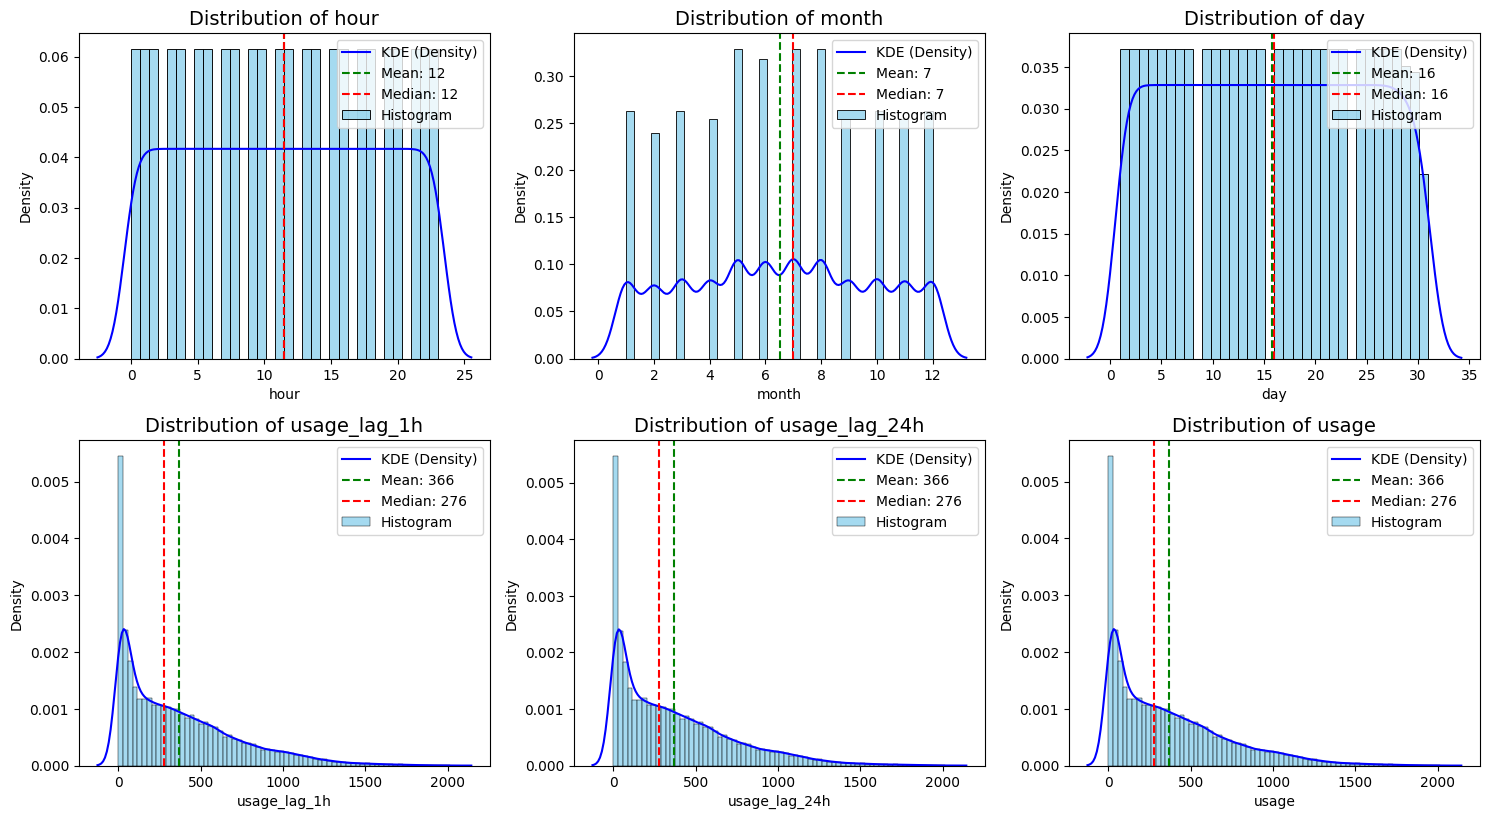

In [501]:
plotter.plot_distribution_histogram()

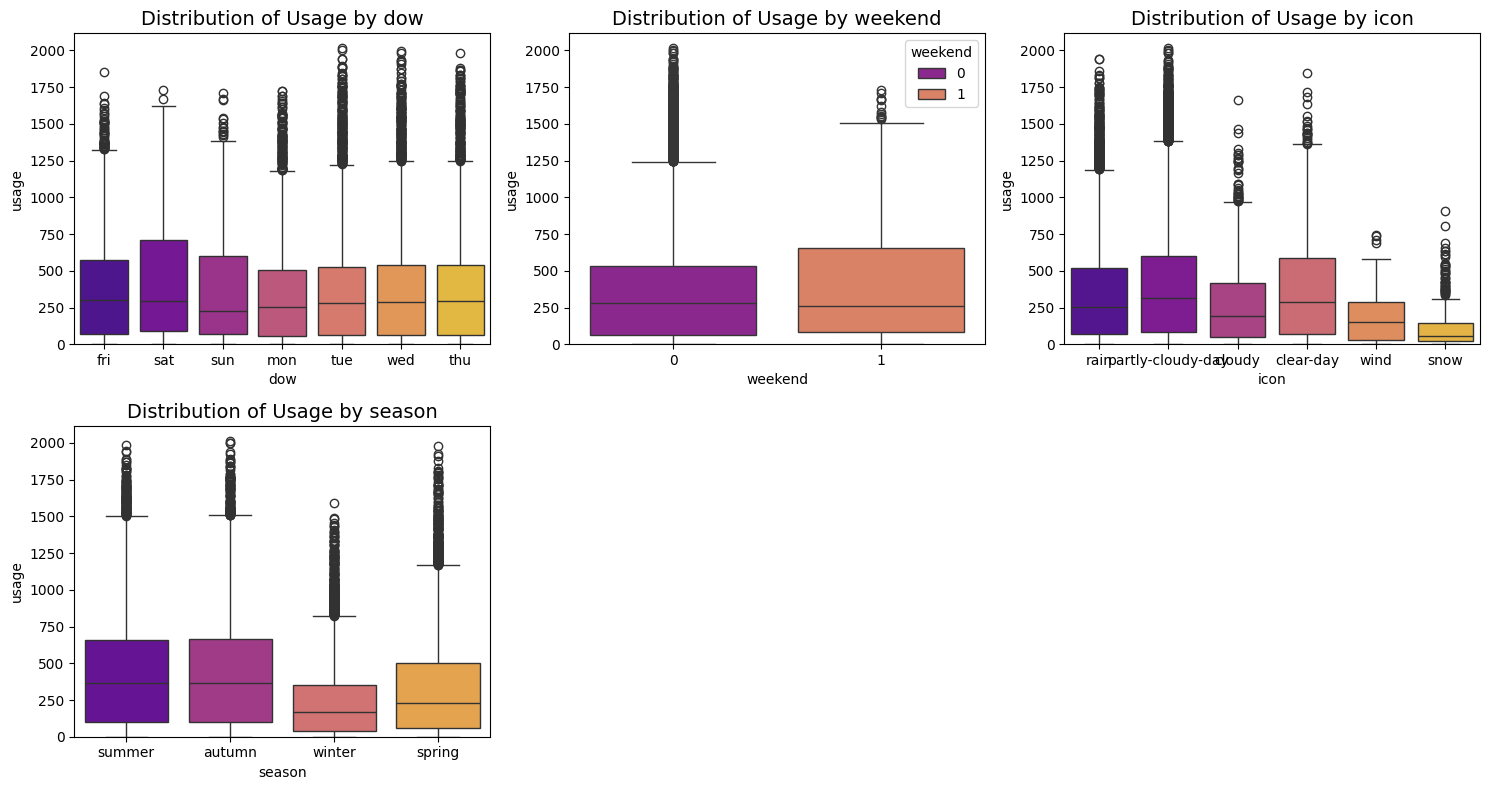

In [502]:
plotter.plot_categorical_boxplots()

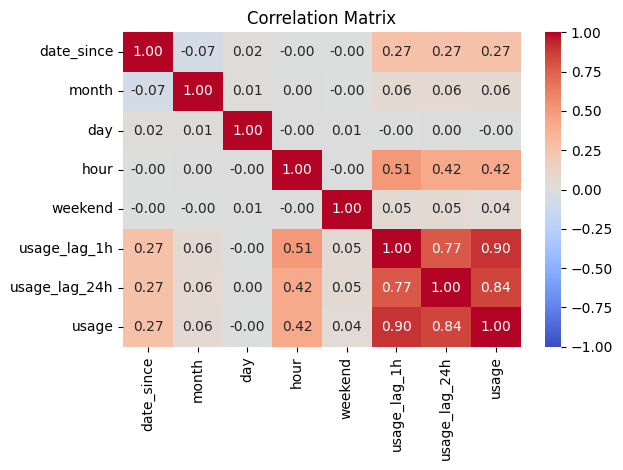

In [503]:
plotter.plot_correlation_matrix()

## 6. Date Preprocessing

In [504]:
df = pd.read_csv("../data/processed/dataset.csv")
df.head()

,date_since,month,day,hour,dow,weekend,season,icon,usage_lag_1h,usage_lag_24h,usage
0,0,5,1,0,fri,0,summer,rain,0.0,0.0,9.0
1,0,5,1,1,fri,0,summer,rain,9.0,0.0,0.0
2,0,5,1,2,fri,0,summer,rain,0.0,0.0,4.0
3,0,5,1,3,fri,0,summer,rain,4.0,0.0,1.0
4,0,5,1,4,fri,0,summer,rain,1.0,0.0,4.0


In [505]:
df_poly = df.copy()

# One-hot encoding for categorical features
categorical_cols = ["season", 'dow', 'icon']

valid_cat_cols = [c for c in categorical_cols if c in df_poly.columns]
df_poly = pd.get_dummies(df_poly, columns=valid_cat_cols, drop_first=True).astype(int)


In [506]:
# Log transform for usage, usage_lag_1h, usage_lag_24h
df_poly["usage"] = pd.DataFrame(np.log1p(df_poly["usage"]))
df_poly["usage_lag_1h"] = pd.DataFrame(np.log1p(df_poly["usage_lag_1h"]))
df_poly["usage_lag_24h"] = pd.DataFrame(np.log1p(df_poly["usage_lag_24h"]))

In [507]:
from typing import List

def add_poly_features(data: pd.DataFrame, features: List[str], degree: int = 2) -> pd.DataFrame:
    for feature in features:
        for i in range(2, degree + 1):
            data[f"{feature}^{i}"] = data[feature]**i
    
    return data

def add_interaction_features(data: pd.DataFrame, 
                             primary_feature: str, 
                             interaction_features: List[str],
                             degree: int = 2) -> pd.DataFrame:
    
    add_poly_features(data, [primary_feature], degree)

    for feature in interaction_features:
        add_poly_features(data, [feature], degree)

        data[f"{primary_feature}_x_{feature}"] = data[primary_feature] * data[feature]
        
        for i in range(2, degree + 1):
            data[f"{primary_feature}^{i}_x_{feature}"] = data[primary_feature]**i * data[feature]
            
    return data

In [508]:
df_poly.columns

Index(['date_since', 'month', 'day', 'hour', 'weekend', 'usage_lag_1h',
       'usage_lag_24h', 'usage', 'season_spring', 'season_summer',
       'season_winter', 'dow_mon', 'dow_sat', 'dow_sun', 'dow_thu', 'dow_tue',
       'dow_wed', 'icon_cloudy', 'icon_partly-cloudy-day', 'icon_rain',
       'icon_snow', 'icon_wind'],
      dtype='object')

In [531]:
primary_feature = "hour"
interaction_features = ["icon_cloudy","icon_partly-cloudy-day", "icon_rain", "icon_snow", "icon_wind"]
df_poly = add_interaction_features(data=df_poly, primary_feature=primary_feature, interaction_features=interaction_features,degree=4)
df_poly = add_interaction_features(data=df_poly,primary_feature=primary_feature, interaction_features=["weekend"], degree=2)
df_poly = add_interaction_features(data=df_poly,primary_feature=primary_feature, interaction_features=["day"], degree=2)
df_poly = add_interaction_features(data=df_poly,primary_feature=primary_feature, interaction_features=["usage_lag_1h"], degree=1)
df_poly = add_interaction_features(data=df_poly,primary_feature=primary_feature, interaction_features=["usage_lag_24h"], degree=1)



In [573]:
# Get X (features), y (label)
y = df_poly["usage"]
X = df_poly.drop(columns="usage")

y.info()
X.info()

<class 'pandas.core.series.Series'>
RangeIndex: 38016 entries, 0 to 38015
Series name: usage
Non-Null Count  Dtype  
--------------  -----  
38016 non-null  float64
dtypes: float64(1)
memory usage: 297.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38016 entries, 0 to 38015
Data columns (total 67 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   date_since                       38016 non-null  int64  
 1   month                            38016 non-null  int64  
 2   day                              38016 non-null  int64  
 3   hour                             38016 non-null  int64  
 4   weekend                          38016 non-null  int64  
 5   usage_lag_1h                     38016 non-null  float64
 6   usage_lag_24h                    38016 non-null  float64
 7   season_spring                    38016 non-null  int64  
 8   season_summer                    38016 non-null  int64  
 9

In [574]:
# Convert to numpy array
y_array = y.values
X_array= X.values

In [575]:
def split_data(X: np.ndarray,
               y: np.ndarray,
               test_ratio: float = 0.2,
               seed: int = 42) -> tuple:
    
    data_size = X.shape[0]
    train_size = int(data_size * ( 1 - test_ratio))

    # Create a randomized index list
    np.random.seed(seed=seed)
    # indices = np.random.permutation(data_size)
    indices = np.arange(data_size)
    
    # Get index for train/test 
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    # Split data by randomized index
    X_train, X_test = X[train_indices], X[test_indices] 
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test

In [576]:
# Split dataset to Train/Test (Test size = 0.2)
X_train, X_test, y_train, y_test = split_data(X_array, y_array)

# Split Train dataset to Train/Valid (Valid size = 0.15)
X_train, X_valid, y_train, y_valid = split_data(X_train, y_train)

In [577]:
# MinMaxScaler for numerical features
import numpy as np

class MinMaxScaler:
    def __init__(self):
        self.min = None
        self.max = None
    
    def fit(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)

    def transform(self, data):
        if self.min is None or self.max is None:
            raise Exception(".fit() must be called before .transform()!")
        
        return (data - self.min) / (self.max - self.min)


    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [578]:
# MinMax Scaling X_array
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)


## 7. Modeling

In [581]:
import numpy as np
import matplotlib.pyplot as plt

class PolynomialRidge:
    def __init__(self, X, y, epochs, batch_size, learning_rate, alpha):
        self.X = X
        self.y = y
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = learning_rate
        self.alpha = alpha
        self.data_size = X.shape[0]

        self.theta = np.random.randn(X.shape[1])
        self.loss = []
        self.accuracy = []

    def predict(self, X: np.ndarray) -> np.ndarray:
        result = X @ self.theta
        return result
    
    def r2_score(self, y: np.ndarray, y_predict: np.ndarray) -> np.floating:
        tss = np.sum((y - np.mean(y)) ** 2)
        rss = np.sum((y - y_predict) ** 2)

        return 1 - (rss / tss)

    def mse(self, y: np.ndarray, y_predict: np.ndarray) -> np.floating:
        mse = (y - y_predict) ** 2
        loss = np.mean(mse)

        return loss

    def fit(self):
        for epoch in range(self.epochs):
            print(f"--------------Epoch {epoch}--------------")
            # Get random index list
            indices = np.random.permutation(self.data_size)

            # Create shuffled train data
            X_rand = self.X[indices]
            y_rand = self.y[indices]
            
            # Metrics epoch 
            loss_epoch = []
            r2_score_epoch = [] 

            for batch in range(0, self.data_size, self.batch_size):
                # Get train data for batch
                X_batch = X_rand[batch:batch + self.batch_size]
                y_batch = y_rand[batch:batch + self.batch_size]

                # Predict y
                y_predict = self.predict(X_batch)

                # Loss Ridge
                theta_ridge = self.theta.copy()
                theta_ridge[0] = 0

                loss_batch = self.mse(y_batch, y_predict) + self.alpha * np.sum(theta_ridge**2)
                loss_epoch.append(loss_batch)

                # R2score
                r2_score = self.r2_score(y_batch, y_predict)
                r2_score_epoch.append(r2_score)

                # Gradient
                error = y_predict - y_batch
                grad_mse = (2 / self.batch_size) * (X_batch.T @ error)
                grad_ridge = 2 * self.alpha * theta_ridge

                gradient = grad_mse + grad_ridge

                # Update weights
                self.theta = self.theta - self.lr * gradient
            
            np.set_printoptions(suppress=True, precision=4, linewidth=150)
            print(f"loss: {loss_epoch[-1]:.4f}")
            print(f"theta: {self.theta}")

            avg_loss = np.mean(loss_epoch)
            avg_r2 = np.mean(r2_score_epoch)

            self.loss.append(avg_loss)
            self.accuracy.append(avg_r2)

        result = {"status": "Completed",
                  "final_mse": self.loss[-1],
                  "final_r2": self.accuracy[-1]
                  }
        
        return result

    def plot(self):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.loss, color="red")
        plt.xlabel("Epochs")
        plt.ylabel("RMSE")

        plt.subplot(1, 2, 2)
        plt.plot(self.accuracy, color="blue")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")

        plt.show()

### 7.1. Fit model

In [ ]:
def add_bias(X: np.ndarray) -> np.ndarray:
    X_bias = np.column_stack((np.ones(X.shape[0]), X))
    return X_bias

# Add Bias
X_train_poly = add_bias(X_train_scaled)

In [582]:
model = PolynomialRidge(X_train, 
                         y_train,
                         epochs=350,
                         batch_size=256,
                         learning_rate=0.01,
                         alpha=0.001)

model.fit()

--------------Epoch 0--------------
loss: 0.8766
theta: [ 1.134   0.2383  0.8637  1.5641  0.3806  0.1411  2.1917  1.3535 -0.1901  0.5326 -0.2789 -0.5045  0.2069 -1.5002 -1.442  -0.5531 -0.8942  0.339
 -0.4224 -1.2576  1.4106 -0.2289  0.5727 -0.9956 -0.1718  0.1361 -1.1234  0.4003 -0.5904 -0.2887 -0.6013  1.8464  0.4704 -0.5718  1.3049 -0.7667
  0.5831 -1.6373 -1.0466  0.3485  0.889   0.323   0.046  -0.1653 -1.3601 -0.6166 -0.512   1.0028  0.2907 -1.7784  0.3127 -0.3917 -0.6812  0.6069
  1.0254  0.9259 -0.8393 -0.3098  0.3296  0.9728 -0.1035  0.0958 -0.8789 -1.2333  0.9582  1.4855  0.4527  1.521 ]
--------------Epoch 1--------------


loss: 0.6170
theta: [ 1.0833  0.2479  0.748   1.355   0.4552  0.1879  2.255   1.4047 -0.0978  0.394  -0.2781 -0.5817  0.0525 -1.2962 -1.2792 -0.5921 -0.8546  0.351
 -0.4364 -1.249   1.3529 -0.234   0.6385 -0.9378 -0.1224  0.1485 -1.1086  0.4122 -0.5907 -0.294  -0.6076  1.8348  0.4547 -0.5855  1.2875 -0.6822
  0.6609 -1.5639 -0.981   0.354   0.8935  0.3286  0.0712 -0.1453 -1.3418 -0.6016 -0.566   0.9459  0.2351 -1.7976  0.2978 -0.4015 -0.6883  0.6002
  1.0179  0.9186 -0.8406 -0.3115  0.3271  0.9693 -0.0562  0.153  -0.8259 -1.4135  0.8733  1.422   0.5307  1.5865]
--------------Epoch 2--------------
loss: 1.0424
theta: [ 1.0574  0.2604  0.6636  1.22    0.4849  0.2066  2.3093  1.4489 -0.0405  0.3045 -0.2692 -0.6252 -0.0739 -1.1485 -1.1401 -0.6083 -0.8109  0.3639
 -0.4406 -1.2342  1.3046 -0.2396  0.6542 -0.9274 -0.1165  0.1617 -1.0929  0.425  -0.5913 -0.2998 -0.6144  1.8228  0.4487 -0.5895  1.28   -0.6314
  0.7024 -1.5248 -0.947   0.3657  0.9042  0.3403  0.0838 -0.1389 -1.336  -0.598  -0.61

{'status': 'Completed',
 'final_mse': np.float64(0.20226086748743813),
 'final_r2': np.float64(0.9221630990076618)}

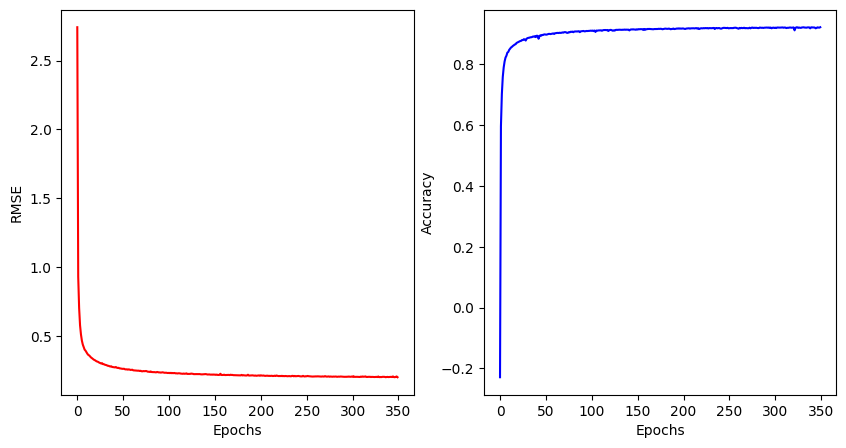

In [583]:
model.plot()

### 7.2. Validation

In [584]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_diagnostics(y_true, y_pred, name):
    # Compute Residuals = Actual - Predicted
    residuals = y_true - y_pred
    
    plt.figure(figsize=(18,8))

    # --- Actual vs Predicted ---'
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, color="blue", alpha=0.4)
    
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)
    
    plt.title(f"{name}: Actual vs Predicted (Log Scale)", fontsize=14)
    plt.xlabel("Actual (Log Usage)", fontsize=12)
    plt.ylabel("Predicted (Log Usage)", fontsize=12)

    # --- Residual Plot ---
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_pred, y=residuals, color="green", alpha=0.4)
    
    plt.axhline(y=0, color="red", linestyle="--", linewidth=2)
    
    plt.title(f"{name}: Residuals", fontsize=14)
    plt.xlabel("Log Usage", fontsize=12)
    plt.ylabel("Residuals", fontsize=12)

    plt.tight_layout()
    plt.show()

In [585]:
# MinMax scaling for X_valid 
X_valid_scaled = scaler.transform(X_valid)

# Add bias
X_valid = add_bias(X_valid_scaled)

In [586]:
# Validation
y_predict = model.predict(X_valid)
loss_valid = model.mse(y_valid, y_predict)
r2_valid = model.r2_score(y_valid, y_predict)

print(f"mse: {loss_valid}, r2: {r2_valid}")

mse: 0.1657728874155233, r2: 0.9173025808241252


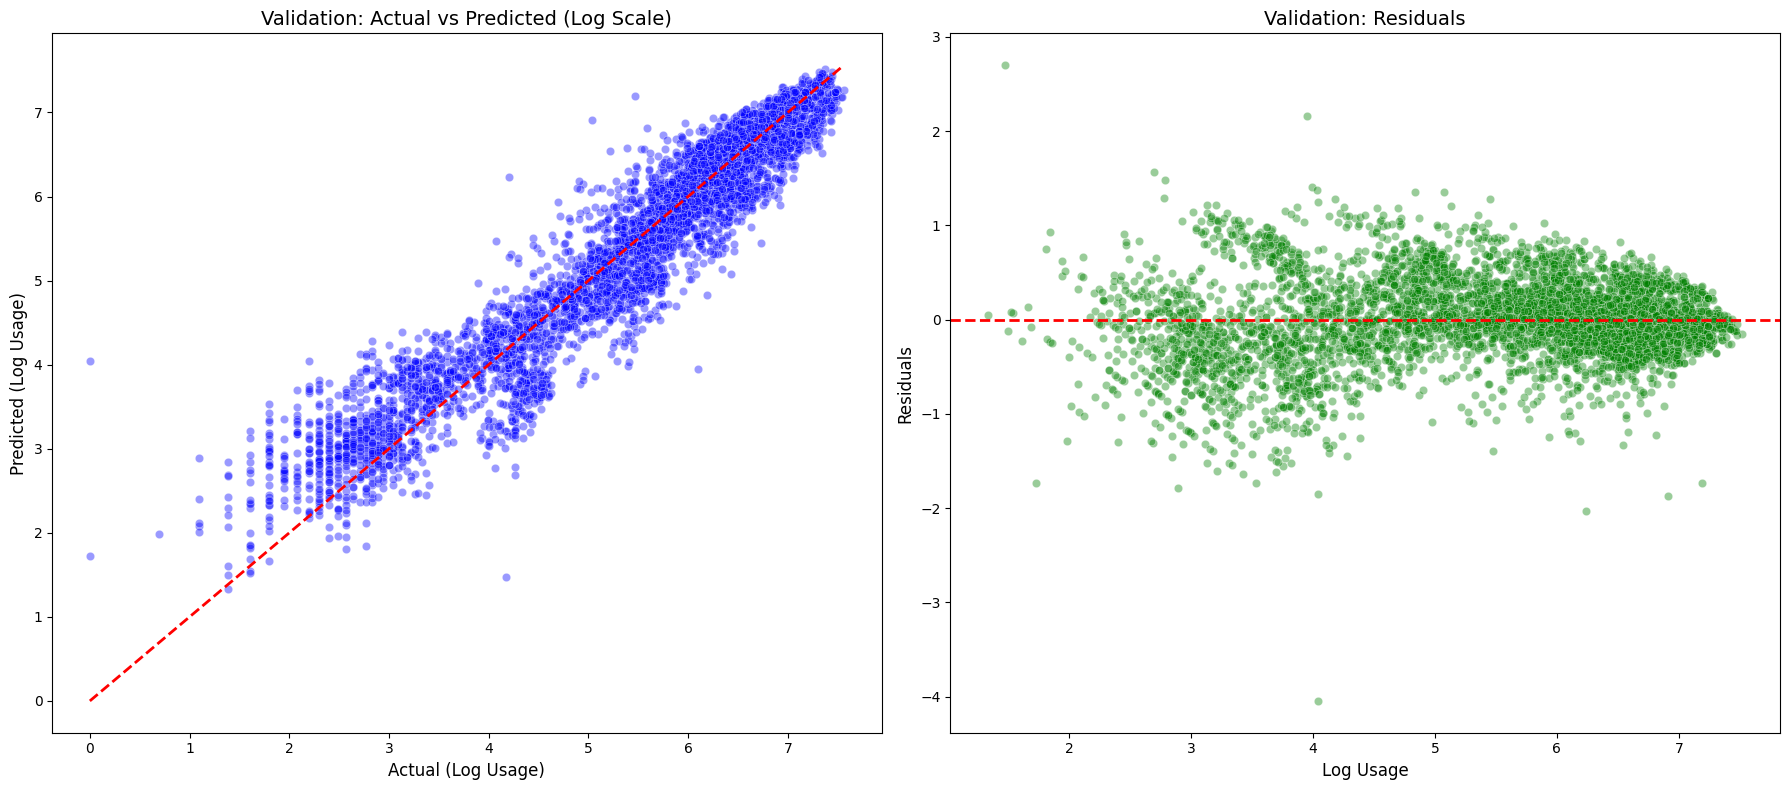

In [587]:
plot_diagnostics(y_valid, y_predict, "Validation")

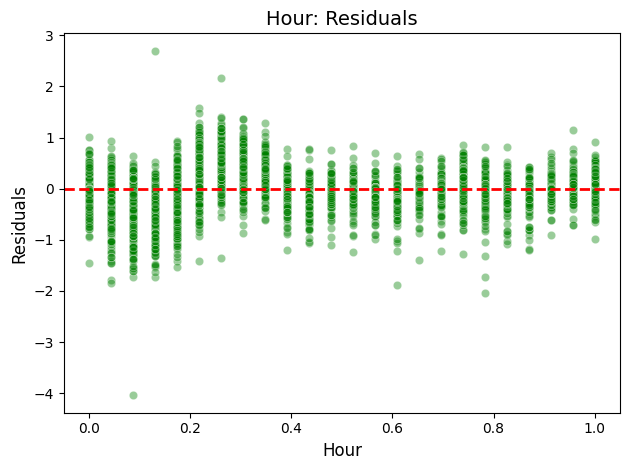

In [588]:
features = X_valid[:,4]


sns.scatterplot(x=features, y=(y_valid - y_predict), color="green", alpha=0.4)

plt.axhline(y=0, color="red", linestyle="--", linewidth=2)

plt.title(f"Hour: Residuals", fontsize=14)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Residuals", fontsize=12)

plt.tight_layout()
plt.show()

### 7.3. Testing

In [589]:
# MinMax scaling for X_test 
X_test_scaled = scaler.transform(X_test)

# Add bias
X_test = add_bias(X_test_scaled)

In [590]:
# Testing
y_predict = model.predict(X_test)
loss_test = model.mse(y_test, y_predict)
r2_test = model.r2_score(y_test, y_predict)

print(f"mse: {loss_test}, r2: {r2_test}")

mse: 0.17249118136085223, r2: 0.9179996166300843


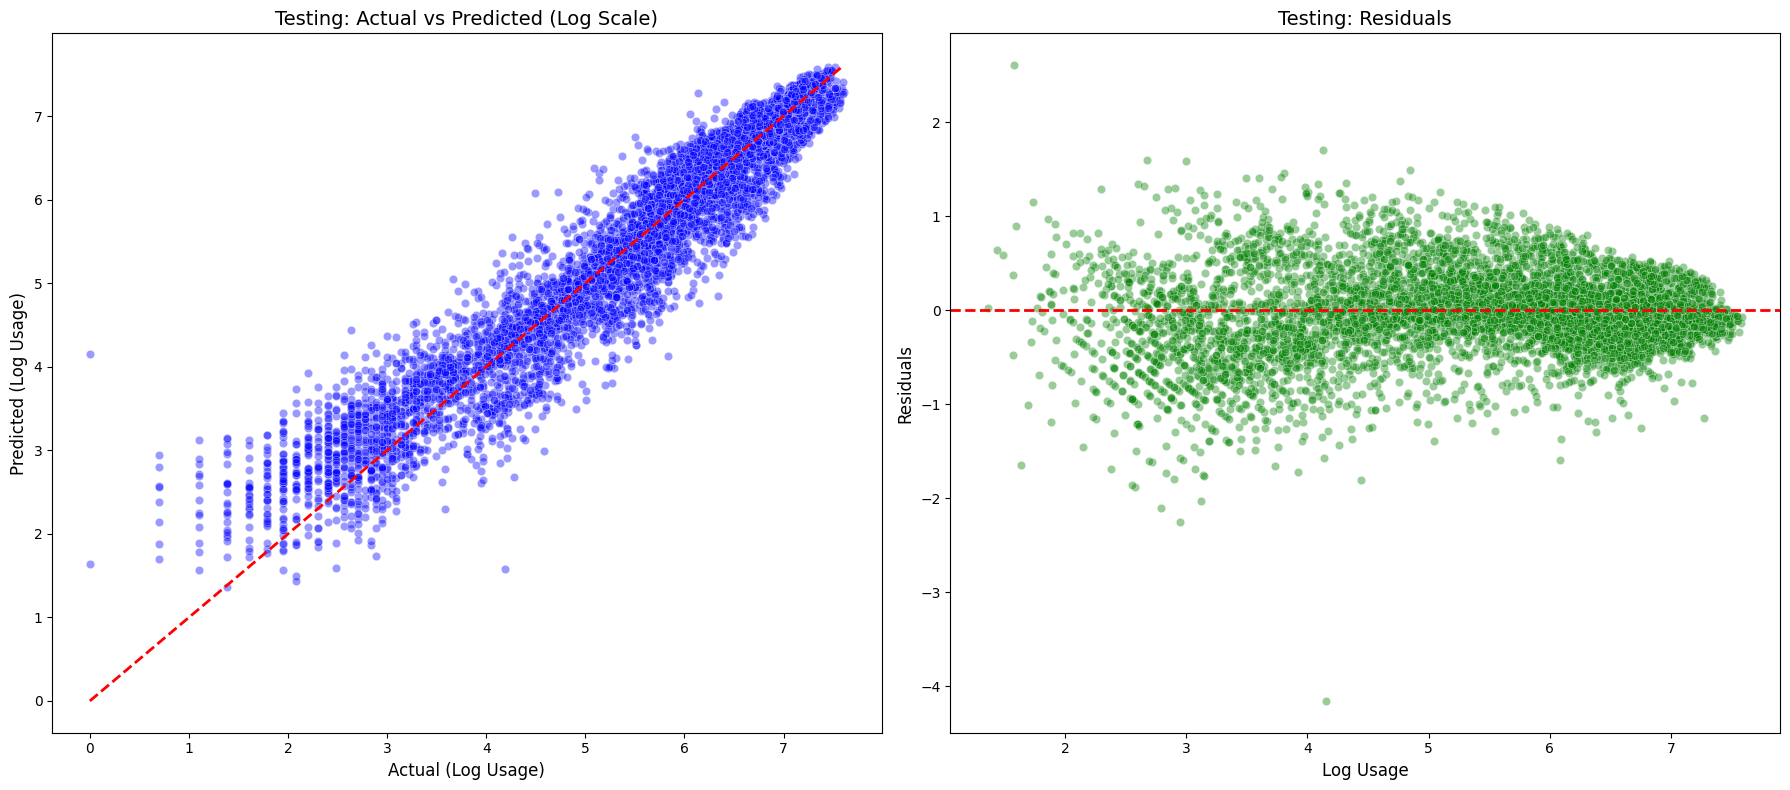

In [591]:
plot_diagnostics(y_test, y_predict, "Testing")

## 8. Evaluation

In [592]:
import pandas as pd
import numpy as np

def evaluate_model_performance(model, X_train, y_train, X_test, y_test):
    # 1. Model Predict
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log = model.predict(X_test)
    
    # 2. Revert
    y_train_usd = np.expm1(y_train)
    y_test_usd = np.expm1(y_test)
    y_train_pred_usd = np.expm1(y_train_pred_log)
    y_test_pred_usd = np.expm1(y_test_pred_log)
    
    # 3. Compute Metrics
    def compute_metrics(y_true, y_pred, name):
        mse = model.mse(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_true - y_pred))
        r2 = model.r2_score(y_true, y_pred)

        # Compute WAPE (Weighted Absolute Percentage Error)
        total_abs_error = np.sum(np.abs(y_true - y_pred))
        total_actual = np.sum(y_true)
    
        if total_actual == 0:
            wape = 0
        else:
            wape =  (total_abs_error / total_actual) * 100
        
        return [name, r2, rmse, mae, wape]

    # 4. Sumarize
    metrics_train = compute_metrics(y_train_usd, y_train_pred_usd, "Train Set")
    metrics_test = compute_metrics(y_test_usd, y_test_pred_usd, "Test Set")
    
    df_metrics = pd.DataFrame([metrics_train, metrics_test], 
                              columns=["Dataset", "R2 Score", "RMSE", "MAE", "WAPE (%)"])
    
    return df_metrics, y_test_usd, y_test_pred_usd

In [593]:
df_results, y_test_real, y_test_pred = evaluate_model_performance(model, X_train, y_train, X_test, y_test)
display(df_results.round(2))

,Dataset,R2 Score,RMSE,MAE,WAPE (%)
0,Train Set,0.89,96.53,60.72,19.91
1,Test Set,0.86,155.00,101.63,21.82
